<a href="https://www.kaggle.com/code/peremartramanonellas/gan-tutorial-4-how-to-create-a-conditional-gan?scriptVersionId=122943857" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    background-color: AliceBlue;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h2 {
    text-align: center;
    background-color: HoneyDew;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h3 {
    text-align: center;
    background-color: MintCream;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}


body, p {
    font-family: monospace;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: monospace;
    color: purple;
}
</style>
""")

# How to create a Conditional GAN.
A GAN, as we already know, allows us to generate images similar to those of the Dataset with which it has been trained. 

**A conditional GAN also allows us to indicate which kind of images we want to generate.**

This notebook is part of a series of notebooks about GANs. I'm ging top use the MNIST Dataset. The same used in the first article to create a simple GAN. If you would like to compare the code to see the differences between a GAN and a Conditional GAN it's a good Idea give a look at the first notebook: https://www.kaggle.com/code/peremartramanonellas/gan-tutorial-first-dcgan-using-tensorflow

## If you like the notebook, please consider **UPVOTING IT**. I will be pleased, and it encourages me to continue publishing.

# General Structure of a Conditional GAN

The structure is mostly the same as for a normal GAN. We have a Generator who makes the images and a Discriminator who decides if the images are real and belong to the Dataset or if they came from the Generator.

It is important to note that both the Generator and the Discriminator must now receive the class to which the images belong.

As you may have already guessed, both the Generator and the Discriminator will be Multipath models, so we will no longer be able to use the Sequential API. Instead, we will use the Functional API.


## Import Libraries

In [2]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from keras.utils.vis_utils import plot_model

print (tf.__version__)

2.11.0


## Support functions

Function to print the images. 

In [3]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    #display.clear_output(wait=False)  

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap = "binary")
        plt.axis("off")
    plt.show()

This function loads the Dataset from Keras, and normalizes the value of the pixels of the images so that they have values between -1 and 1.
The function returns both the image and its class.

In [4]:
def load_dataset():
  # download the training images
  (X_train, y_train), (_, _) = keras.datasets.mnist.load_data()

  # normalize pixel values
  X_train = X_train.astype(np.float32) / 255

  # reshape and rescale
  X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

  return [X_train, y_train]

The function receives a Dataset and returns the number of elements indicated in n_samples. The first element is decided by a random number, which gives a certain randomness to the data.

In [5]:
def get_dataset_samples(dataset, n_samples):
  images, labels = dataset

  ix = np.random.randint(0, images.shape[0], n_samples)

  X, labels = images[ix], labels[ix]

  y = np.ones((n_samples, 1))
  return [X, labels], y

The next function receives a Dataset and returns the number of elements indicated in *n_samples*. The first element is decided by a random number, which gives a certain randomness to the data.

Apart from returning the images and the category to which they belong, it also returns a label indicating that the images are true.

In [6]:
def get_dataset_samples(dataset, n_samples):
  images, labels = dataset

  ix = np.random.randint(0, images.shape[0], n_samples)

  X, labels = images[ix], labels[ix]

  y = np.ones((n_samples, 1))
  return [X, labels], y

This function is responsible for creating the noise that the Generator receives as input. It returns both the noise and some random class indicators that show which class the image will belong to.

In [7]:
def generate_noise(noise_size, n_samples, n_classes=10):
  #generate noise
  x_input = np.random.randn(noise_size * n_samples)
  
  #shape to adjust to batch size
  z_input = x_input.reshape(n_samples, noise_size)

  #generate labels
  labels = np.random.randint(0, n_classes, n_samples)
  return [z_input, labels]

The next function creates images using the Generator. To achieve this, it first calls the function generate_noise to get the input for the generator, and then calls it to get the images.

In [8]:
def generate_fake_samples(generator, latent_dim, n_samples): 
  #get the noise calling the function
  z_input, labels_input = generate_noise(latent_dim, n_samples)

  images = generator.predict([z_input, labels_input])

  #create class labes
  y = np.zeros((n_samples, 1))
  return [images, labels_input], y

# The Generator
As you know, a Generator must receive as an Input some data in Gaussian form, also called Noise.

In the case of a conditional GAN, the noise will be accompanied by an indicator of the class to which the generated image must belong, that is, the conditional information. 

As we have two inputs, our model with have two branches, and we can't use the Sequential API. We are going to use the Functional API to create the Generator, and also the Discriminator. 


In [9]:
#define the  generator model
def define_generator(latent_dim, n_classes=10):
  # label input
  in_label = keras.layers.Input(shape=(1,))
  # embedding for categorical input
  li = keras.layers.Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes = 7 * 7
  li = keras.layers.Dense(n_nodes)(li)
  # reshape to additional channel
  li = keras.layers.Reshape((7, 7, 1))(li)
  # image generator input
  in_lat = keras.layers.Input(shape=(latent_dim,))
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  gen = keras.layers.Dense(n_nodes)(in_lat)

  gen = keras.layers.LeakyReLU(alpha=0.2)(gen)
  gen = keras.layers.Reshape((7, 7, 128))(gen)
  # merge image gen and label input
  merge = keras.layers.Concatenate()([gen, li])
  # upsample to 14x14
  gen = keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                                     activation=keras.layers.LeakyReLU(alpha=0.2))(merge)
  gen = keras.layers.BatchNormalization()(gen)
  # upsample to 28x28
  gen = keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                                     activation=keras.layers.LeakyReLU(alpha=0.2))(gen)
  gen = keras.layers.BatchNormalization()(gen)
  # output
  out_layer = keras.layers.Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
  # define model
  model = keras.Model([in_lat, in_label], out_layer)
  return model

In [10]:
#size of the noise used as a Input for the generator. 
noise_size = 50

generator = define_generator(noise_size)

generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 6272)         319872      ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                              

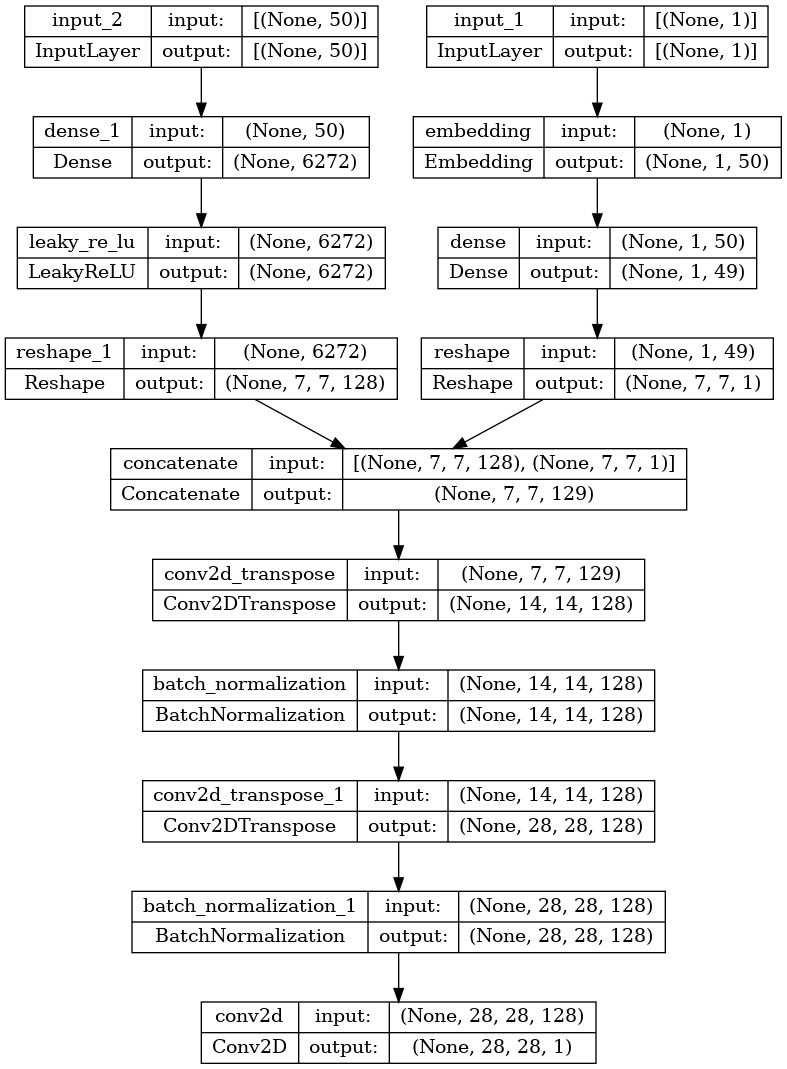

In [11]:
plot_model(generator, show_shapes=True, 
           show_layer_names=True)

In the branch on the right, we can see how the conditional indicator changes to a 7×7×1 shape to adapt to the size of the source image.

On the left branch, the noise is transformed to 7×7×128. Which represents our 7×7 source image with 128 nodes.

These two layers are joined using the Concatenate layer. With that, the conditional indicator is transformed into one more channel, and we have a 7×7×129 image where one of the channels has the information on the class to which it belongs.

# The Discriminator
The Discriminator will be responsible for deciding if an image is from the original Dataset, or if the Generator has created it. 

Apart from the image in this case, as it is a conditional GAN, conditional information is also received that indicates to which class the image belongs.



In [12]:
def define_discriminator(in_shape=(28, 28, 1), n_classes=10):
  in_label = keras.layers.Input(shape=(1,))
  li = keras.layers.Embedding(n_classes, 50)(in_label)

  n_nodes = in_shape[0] * in_shape[1]
  li=keras.layers.Dense(n_nodes)(li)

  li=keras.layers.Reshape((in_shape[0], in_shape[1], 1))(li)

  in_image = keras.layers.Input(shape=in_shape)

  merge = keras.layers.Concatenate()([in_image, li])

  #downsample
  fe=keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', 
                         activation=keras.layers.LeakyReLU(alpha=0.2))(merge)
  fe=keras.layers.Dropout(0.4)(fe)

  #downsample
  fe=keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', 
                         activation=keras.layers.LeakyReLU(alpha=0.2))(fe)
  fe=keras.layers.Dropout(0.4)(fe)

  fe = keras.layers.Flatten()(fe)

  out_layer = keras.layers.Dense(1, activation='sigmoid')(fe)

  model = keras.Model([in_image, in_label], out_layer)

  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

In [13]:
discriminator = define_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 1, 784)       39984       ['embedding_1[0][0]']            
                                                                                                  
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                            

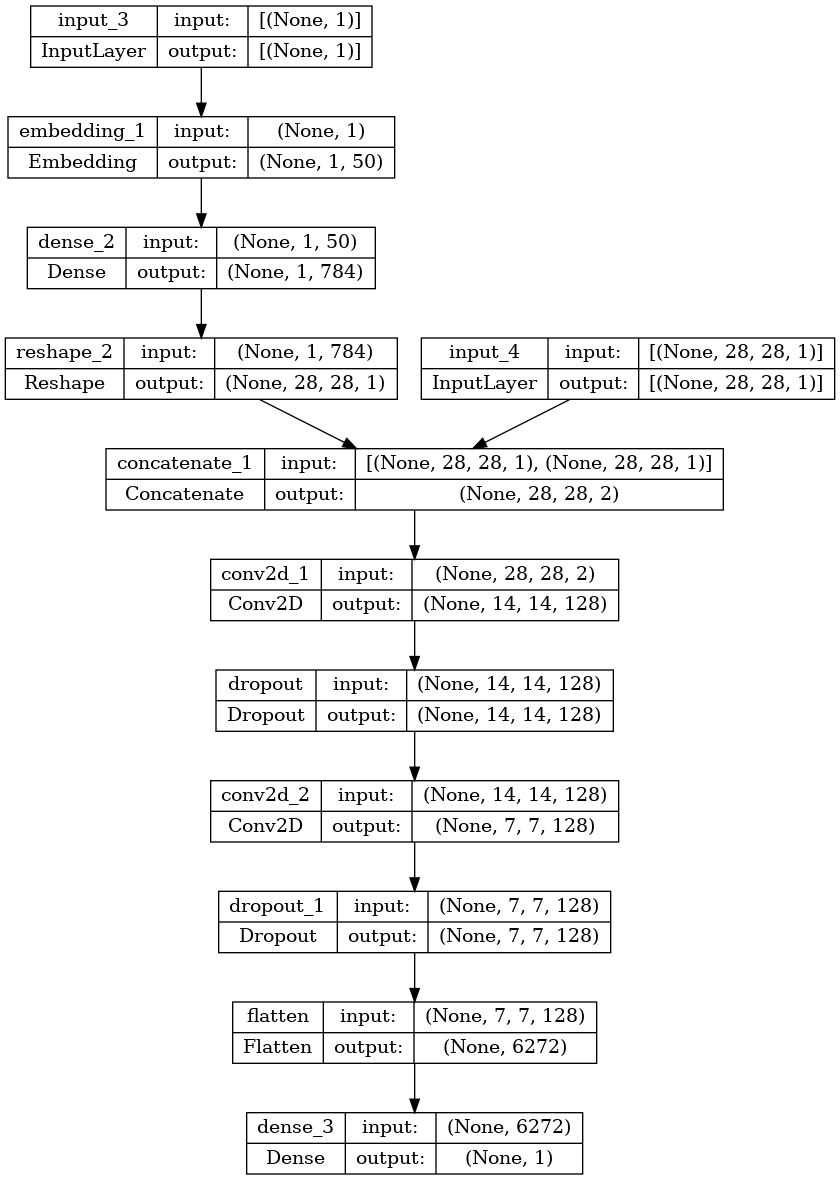

In [14]:
plot_model(discriminator, show_shapes=True, 
           show_layer_names=True)

As with the Generator, we have two separate branches. We receive the conditional information on the left and the image on the right.

We combine the two branches with the Concatenate layer, which returns the image information plus a channel for the conditional information.

To finalize the Discriminator, it would be necessary to carry out the downsampling process. As in any other GAN, to get from the 28×28 image to a binary conclusion indicating whether or not it is an image created by the Generator.

# The complete GAN Model. 
In order to combine the models, I will use a function that receives the Generator and the Discriminator and returns the complete model, already assembled and compiled.

In [15]:
#define the Conditional GAN
def define_gan(generator, discriminator):
  #make discriminator non trainable
  discriminator.trainable = False
  #get noise and label from generator
  gen_noise, gen_label = generator.input
  #get output from generator
  gen_output = generator.output

  #connect image and label input from generator as inputs to discriminator
  gan_output = discriminator([gen_output, gen_label])

  #define the GAN model. 
  model= keras.Model([gen_noise, gen_label], gan_output)

  #compile model
  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [16]:
GAN = define_gan(generator, discriminator)
GAN.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 6272)         319872      ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                            

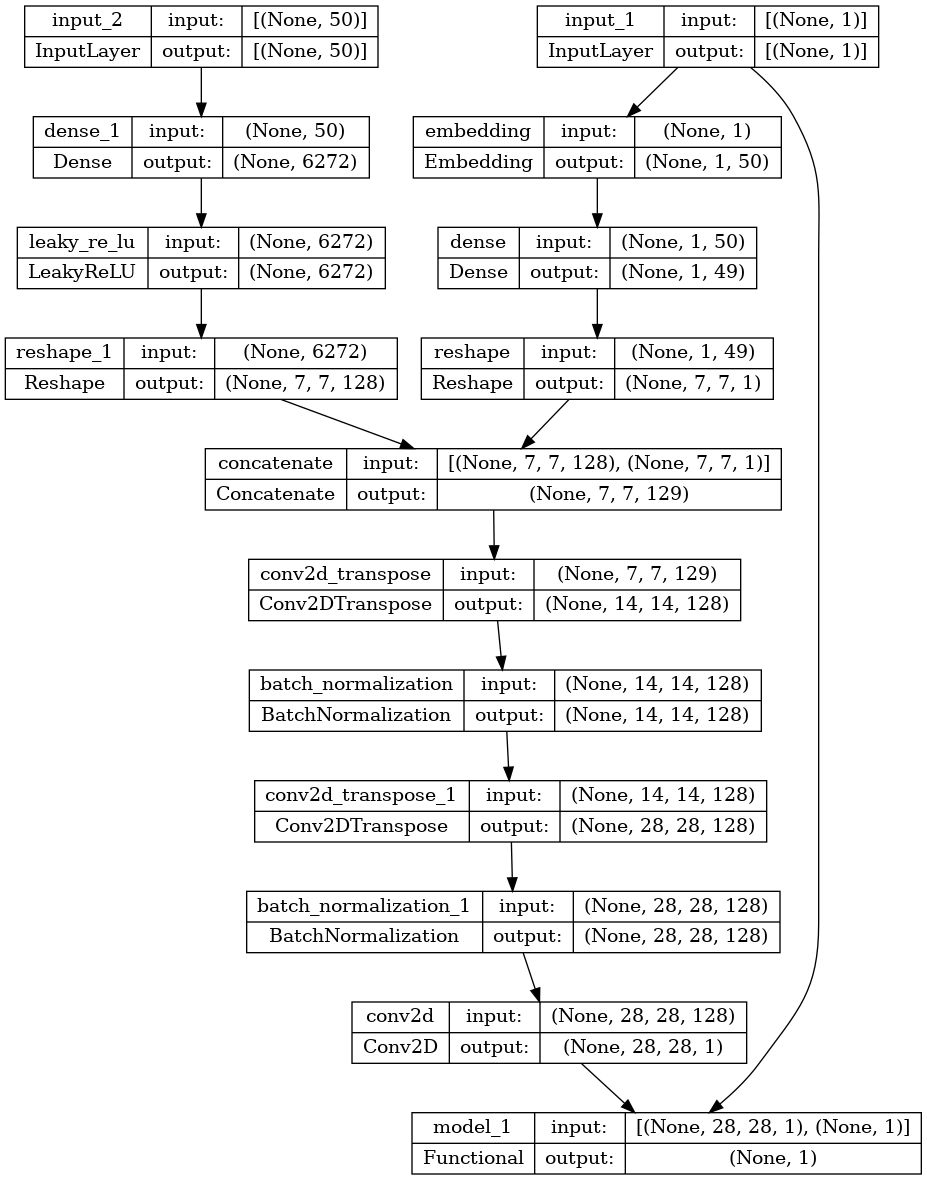

In [17]:
plot_model(GAN, show_shapes=True, 
           show_layer_names=True)

Even though the structure seems very complex, it is actually a sum of the two models.

# GAN Training
With the models already created, now it's time to train the GAN. The process is simple. We must decide how many epochs we want to train, and each epoch must use all the data from the dataset.

Each step must contain the following actions:

**Train the Discriminator. It is done in two blocks.**
- We pass real images to the discriminator, with their corresponding labels.
- We pass fake images, created with the Generator, to the discriminator, with their corresponding labels.

**Train the Generator.**
- We pass noise marked with true image labels to the GAN. Within the GAN, this noise and labels are used to generate images that are passed to the discriminator, and the generator modifies their weights to reduce the loss. Within the GAN, the discriminator has its layers marked as non-trainable, so only the generator weights can be modified.

In [18]:
tf.keras.backend.clear_session()

In [19]:
def train_gan(generator, discriminator, GAN, dataset, noise_size=100, n_epochs=30, n_batch=512):
  steps = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for e in range(n_epochs):
    # enumerate batches over the training set
    for s in range(steps):
      #TRAIN THE DISCRIMINATOR
      # get randomly selected 'real' samples
      [X_real, labels_real], y_real = get_dataset_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = discriminator.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(generator, noise_size, half_batch)
      # update discriminator model weights
      d_loss2, _ = discriminator.train_on_batch([X_fake, labels], y_fake)

      #TRAIN THE GENERATOR
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_noise(noise_size, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = GAN.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
      (e+1, s+1, steps, d_loss1, d_loss2, g_loss))
    plot_results(X_fake, 8)  
    
  # save the generator model
  generator.save('cgan_generator.h5')

Apart from training the Discriminator and the Generator, some generated images are shown in each epoch, and the model is saved at the end of the training. Only the Generator is saved, which is the one we are interested in using at inference time.

11490434/11490434 [==============================] - 1s 0us/step


2023-03-21 22:08:36.452281: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2/2 [==============================] - 0s 5ms/step


2023-03-21 22:08:43.047283: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-21 22:08:44.333135: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/model_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


>1, 1/468, d1=0.750, d2=0.695 g=0.694
2/2 [==============================] - 0s 4ms/step
>1, 2/468, d1=0.630, d2=0.696 g=0.627
2/2 [==============================] - 0s 5ms/step
>1, 3/468, d1=0.555, d2=0.698 g=0.569
2/2 [==============================] - 0s 5ms/step
>1, 4/468, d1=0.472, d2=0.701 g=0.524
2/2 [==============================] - 0s 4ms/step
>1, 5/468, d1=0.406, d2=0.703 g=0.479
2/2 [==============================] - 0s 4ms/step
>1, 6/468, d1=0.341, d2=0.707 g=0.427
2/2 [==============================] - 0s 4ms/step
>1, 7/468, d1=0.265, d2=0.711 g=0.360
2/2 [==============================] - 0s 4ms/step
>1, 8/468, d1=0.222, d2=0.715 g=0.310
2/2 [==============================] - 0s 4ms/step
>1, 9/468, d1=0.169, d2=0.718 g=0.272
2/2 [==============================] - 0s 4ms/step
>1, 10/468, d1=0.138, d2=0.719 g=0.255
2/2 [==============================] - 0s 4ms/step
>1, 11/468, d1=0.109, d2=0.716 g=0.236
2/2 [==============================] - 0s 4ms/step
>1, 12/468, d1=0.09

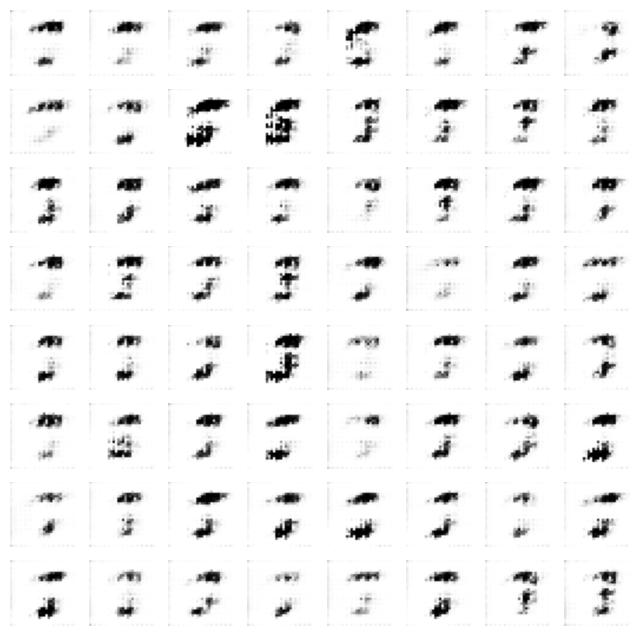

2/2 [==============================] - 0s 5ms/step
>2, 1/468, d1=0.460, d2=0.489 g=0.060
2/2 [==============================] - 0s 4ms/step
>2, 2/468, d1=0.396, d2=0.392 g=0.063
2/2 [==============================] - 0s 4ms/step
>2, 3/468, d1=0.440, d2=0.340 g=0.055
2/2 [==============================] - 0s 4ms/step
>2, 4/468, d1=0.388, d2=0.412 g=0.048
2/2 [==============================] - 0s 4ms/step
>2, 5/468, d1=0.423, d2=0.376 g=0.048
2/2 [==============================] - 0s 4ms/step
>2, 6/468, d1=0.306, d2=0.416 g=0.058
2/2 [==============================] - 0s 4ms/step
>2, 7/468, d1=0.361, d2=0.274 g=0.038
2/2 [==============================] - 0s 4ms/step
>2, 8/468, d1=0.317, d2=0.339 g=0.034
2/2 [==============================] - 0s 4ms/step
>2, 9/468, d1=0.389, d2=0.301 g=0.027
2/2 [==============================] - 0s 5ms/step
>2, 10/468, d1=0.341, d2=0.350 g=0.029
2/2 [==============================] - 0s 4ms/step
>2, 11/468, d1=0.391, d2=0.325 g=0.029
2/2 [==============

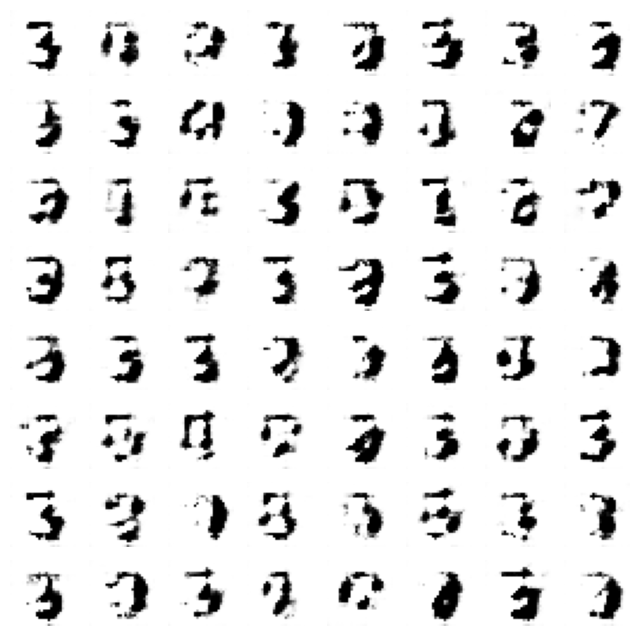

2/2 [==============================] - 0s 4ms/step
>3, 1/468, d1=0.741, d2=0.658 g=0.742
2/2 [==============================] - 0s 4ms/step
>3, 2/468, d1=0.718, d2=0.716 g=0.745
2/2 [==============================] - 0s 4ms/step
>3, 3/468, d1=0.743, d2=0.698 g=0.768
2/2 [==============================] - 0s 4ms/step
>3, 4/468, d1=0.713, d2=0.718 g=0.749
2/2 [==============================] - 0s 4ms/step
>3, 5/468, d1=0.730, d2=0.717 g=0.734
2/2 [==============================] - 0s 5ms/step
>3, 6/468, d1=0.708, d2=0.754 g=0.748
2/2 [==============================] - 0s 4ms/step
>3, 7/468, d1=0.723, d2=0.733 g=0.731
2/2 [==============================] - 0s 4ms/step
>3, 8/468, d1=0.733, d2=0.698 g=0.755
2/2 [==============================] - 0s 4ms/step
>3, 9/468, d1=0.749, d2=0.700 g=0.771
2/2 [==============================] - 0s 5ms/step
>3, 10/468, d1=0.714, d2=0.701 g=0.771
2/2 [==============================] - 0s 4ms/step
>3, 11/468, d1=0.727, d2=0.658 g=0.810
2/2 [==============

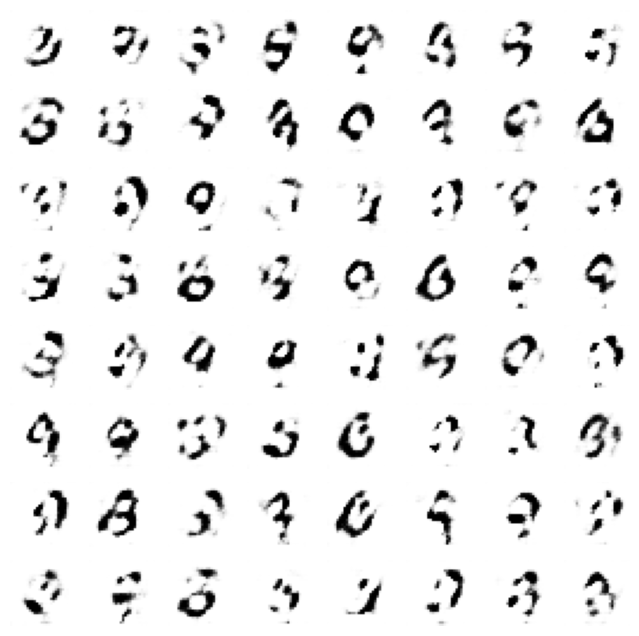

2/2 [==============================] - 0s 4ms/step
>4, 1/468, d1=0.669, d2=0.701 g=0.764
2/2 [==============================] - 0s 4ms/step
>4, 2/468, d1=0.713, d2=0.672 g=0.747
2/2 [==============================] - 0s 5ms/step
>4, 3/468, d1=0.706, d2=0.718 g=0.737
2/2 [==============================] - 0s 4ms/step
>4, 4/468, d1=0.679, d2=0.733 g=0.738
2/2 [==============================] - 0s 4ms/step
>4, 5/468, d1=0.677, d2=0.682 g=0.731
2/2 [==============================] - 0s 4ms/step
>4, 6/468, d1=0.672, d2=0.709 g=0.739
2/2 [==============================] - 0s 4ms/step
>4, 7/468, d1=0.696, d2=0.669 g=0.749
2/2 [==============================] - 0s 4ms/step
>4, 8/468, d1=0.655, d2=0.664 g=0.746
2/2 [==============================] - 0s 5ms/step
>4, 9/468, d1=0.657, d2=0.668 g=0.734
2/2 [==============================] - 0s 4ms/step
>4, 10/468, d1=0.684, d2=0.682 g=0.735
2/2 [==============================] - 0s 5ms/step
>4, 11/468, d1=0.680, d2=0.685 g=0.734
2/2 [==============

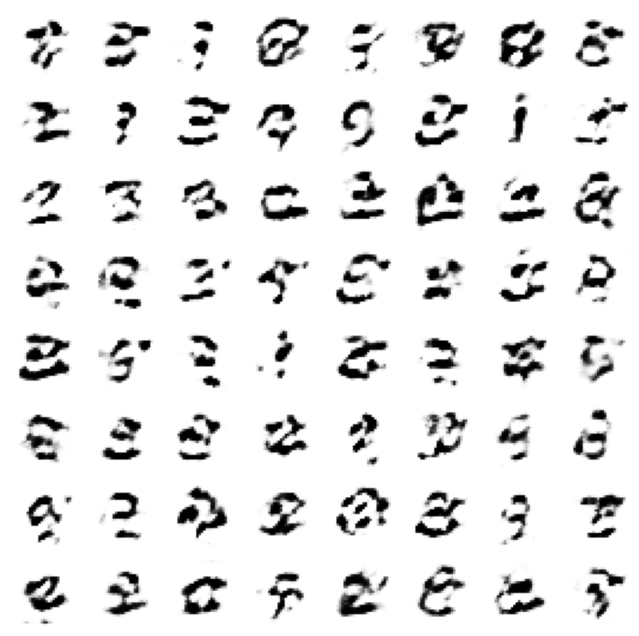

2/2 [==============================] - 0s 4ms/step
>5, 1/468, d1=0.658, d2=0.636 g=0.817
2/2 [==============================] - 0s 5ms/step
>5, 2/468, d1=0.607, d2=0.625 g=0.829
2/2 [==============================] - 0s 4ms/step
>5, 3/468, d1=0.639, d2=0.654 g=0.824
2/2 [==============================] - 0s 4ms/step
>5, 4/468, d1=0.664, d2=0.658 g=0.786
2/2 [==============================] - 0s 4ms/step
>5, 5/468, d1=0.640, d2=0.651 g=0.772
2/2 [==============================] - 0s 4ms/step
>5, 6/468, d1=0.666, d2=0.681 g=0.784
2/2 [==============================] - 0s 4ms/step
>5, 7/468, d1=0.672, d2=0.676 g=0.782
2/2 [==============================] - 0s 4ms/step
>5, 8/468, d1=0.620, d2=0.652 g=0.771
2/2 [==============================] - 0s 4ms/step
>5, 9/468, d1=0.609, d2=0.653 g=0.779
2/2 [==============================] - 0s 5ms/step
>5, 10/468, d1=0.643, d2=0.674 g=0.780
2/2 [==============================] - 0s 4ms/step
>5, 11/468, d1=0.649, d2=0.642 g=0.775
2/2 [==============

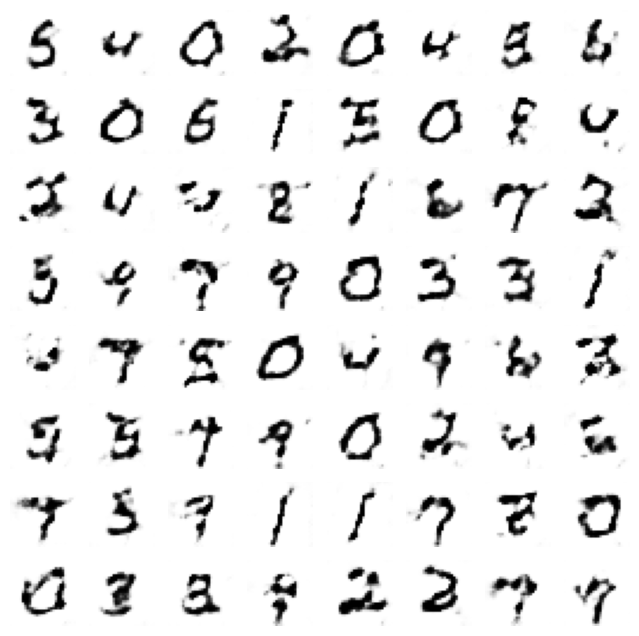

2/2 [==============================] - 0s 4ms/step
>6, 1/468, d1=0.656, d2=0.679 g=0.766
2/2 [==============================] - 0s 4ms/step
>6, 2/468, d1=0.661, d2=0.709 g=0.758
2/2 [==============================] - 0s 4ms/step
>6, 3/468, d1=0.681, d2=0.676 g=0.746
2/2 [==============================] - 0s 4ms/step
>6, 4/468, d1=0.656, d2=0.684 g=0.776
2/2 [==============================] - 0s 4ms/step
>6, 5/468, d1=0.691, d2=0.686 g=0.753
2/2 [==============================] - 0s 4ms/step
>6, 6/468, d1=0.670, d2=0.679 g=0.750
2/2 [==============================] - 0s 4ms/step
>6, 7/468, d1=0.671, d2=0.672 g=0.761
2/2 [==============================] - 0s 4ms/step
>6, 8/468, d1=0.682, d2=0.723 g=0.760
2/2 [==============================] - 0s 4ms/step
>6, 9/468, d1=0.663, d2=0.670 g=0.780
2/2 [==============================] - 0s 4ms/step
>6, 10/468, d1=0.682, d2=0.707 g=0.771
2/2 [==============================] - 0s 4ms/step
>6, 11/468, d1=0.686, d2=0.691 g=0.775
2/2 [==============

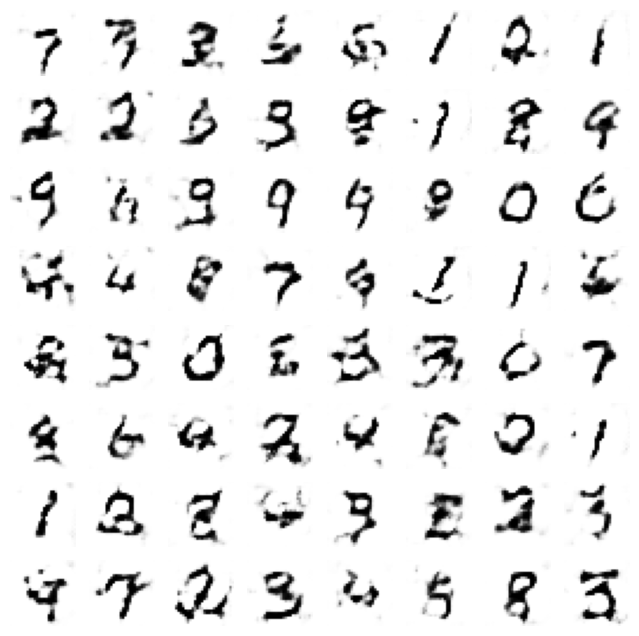

2/2 [==============================] - 0s 4ms/step
>7, 1/468, d1=0.675, d2=0.666 g=0.764
2/2 [==============================] - 0s 4ms/step
>7, 2/468, d1=0.649, d2=0.675 g=0.755
2/2 [==============================] - 0s 4ms/step
>7, 3/468, d1=0.673, d2=0.682 g=0.799
2/2 [==============================] - 0s 4ms/step
>7, 4/468, d1=0.674, d2=0.690 g=0.759
2/2 [==============================] - 0s 4ms/step
>7, 5/468, d1=0.650, d2=0.678 g=0.786
2/2 [==============================] - 0s 5ms/step
>7, 6/468, d1=0.675, d2=0.664 g=0.768
2/2 [==============================] - 0s 5ms/step
>7, 7/468, d1=0.648, d2=0.648 g=0.783
2/2 [==============================] - 0s 5ms/step
>7, 8/468, d1=0.675, d2=0.665 g=0.778
2/2 [==============================] - 0s 4ms/step
>7, 9/468, d1=0.665, d2=0.644 g=0.771
2/2 [==============================] - 0s 4ms/step
>7, 10/468, d1=0.677, d2=0.701 g=0.770
2/2 [==============================] - 0s 4ms/step
>7, 11/468, d1=0.678, d2=0.676 g=0.761
2/2 [==============

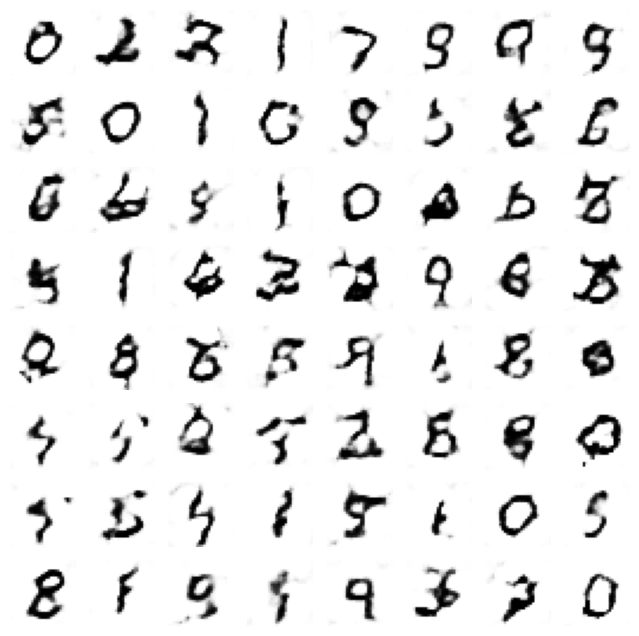

2/2 [==============================] - 0s 4ms/step
>8, 1/468, d1=0.680, d2=0.680 g=0.761
2/2 [==============================] - 0s 4ms/step
>8, 2/468, d1=0.668, d2=0.678 g=0.760
2/2 [==============================] - 0s 4ms/step
>8, 3/468, d1=0.663, d2=0.710 g=0.731
2/2 [==============================] - 0s 4ms/step
>8, 4/468, d1=0.691, d2=0.680 g=0.751
2/2 [==============================] - 0s 4ms/step
>8, 5/468, d1=0.688, d2=0.686 g=0.737
2/2 [==============================] - 0s 5ms/step
>8, 6/468, d1=0.691, d2=0.683 g=0.754
2/2 [==============================] - 0s 4ms/step
>8, 7/468, d1=0.656, d2=0.685 g=0.745
2/2 [==============================] - 0s 4ms/step
>8, 8/468, d1=0.669, d2=0.717 g=0.745
2/2 [==============================] - 0s 4ms/step
>8, 9/468, d1=0.673, d2=0.718 g=0.771
2/2 [==============================] - 0s 4ms/step
>8, 10/468, d1=0.691, d2=0.707 g=0.754
2/2 [==============================] - 0s 4ms/step
>8, 11/468, d1=0.662, d2=0.677 g=0.756
2/2 [==============

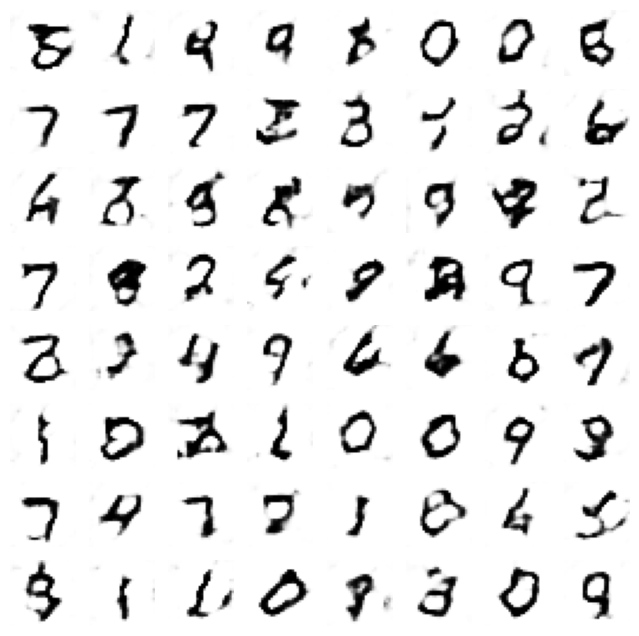

2/2 [==============================] - 0s 5ms/step
>9, 1/468, d1=0.688, d2=0.696 g=0.752
2/2 [==============================] - 0s 4ms/step
>9, 2/468, d1=0.680, d2=0.723 g=0.731
2/2 [==============================] - 0s 5ms/step
>9, 3/468, d1=0.659, d2=0.717 g=0.758
2/2 [==============================] - 0s 4ms/step
>9, 4/468, d1=0.687, d2=0.675 g=0.765
2/2 [==============================] - 0s 4ms/step
>9, 5/468, d1=0.689, d2=0.664 g=0.763
2/2 [==============================] - 0s 4ms/step
>9, 6/468, d1=0.661, d2=0.700 g=0.776
2/2 [==============================] - 0s 4ms/step
>9, 7/468, d1=0.672, d2=0.665 g=0.761
2/2 [==============================] - 0s 4ms/step
>9, 8/468, d1=0.666, d2=0.684 g=0.755
2/2 [==============================] - 0s 4ms/step
>9, 9/468, d1=0.691, d2=0.667 g=0.742
2/2 [==============================] - 0s 5ms/step
>9, 10/468, d1=0.647, d2=0.707 g=0.736
2/2 [==============================] - 0s 5ms/step
>9, 11/468, d1=0.699, d2=0.712 g=0.765
2/2 [==============

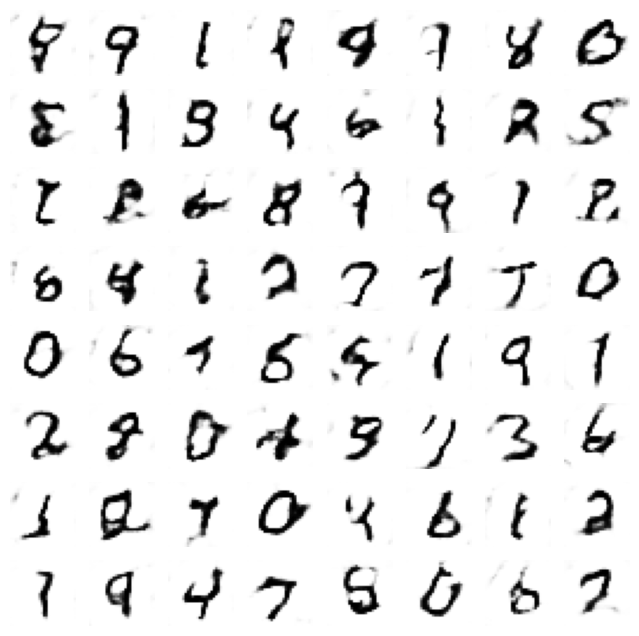

2/2 [==============================] - 0s 4ms/step
>10, 1/468, d1=0.692, d2=0.690 g=0.748
2/2 [==============================] - 0s 5ms/step
>10, 2/468, d1=0.688, d2=0.691 g=0.765
2/2 [==============================] - 0s 4ms/step
>10, 3/468, d1=0.710, d2=0.675 g=0.748
2/2 [==============================] - 0s 4ms/step
>10, 4/468, d1=0.682, d2=0.712 g=0.735
2/2 [==============================] - 0s 4ms/step
>10, 5/468, d1=0.680, d2=0.704 g=0.753
2/2 [==============================] - 0s 4ms/step
>10, 6/468, d1=0.686, d2=0.697 g=0.749
2/2 [==============================] - 0s 4ms/step
>10, 7/468, d1=0.676, d2=0.660 g=0.782
2/2 [==============================] - 0s 5ms/step
>10, 8/468, d1=0.687, d2=0.649 g=0.755
2/2 [==============================] - 0s 5ms/step
>10, 9/468, d1=0.662, d2=0.703 g=0.754
2/2 [==============================] - 0s 4ms/step
>10, 10/468, d1=0.652, d2=0.700 g=0.748
2/2 [==============================] - 0s 4ms/step
>10, 11/468, d1=0.722, d2=0.683 g=0.747
2/2 [===

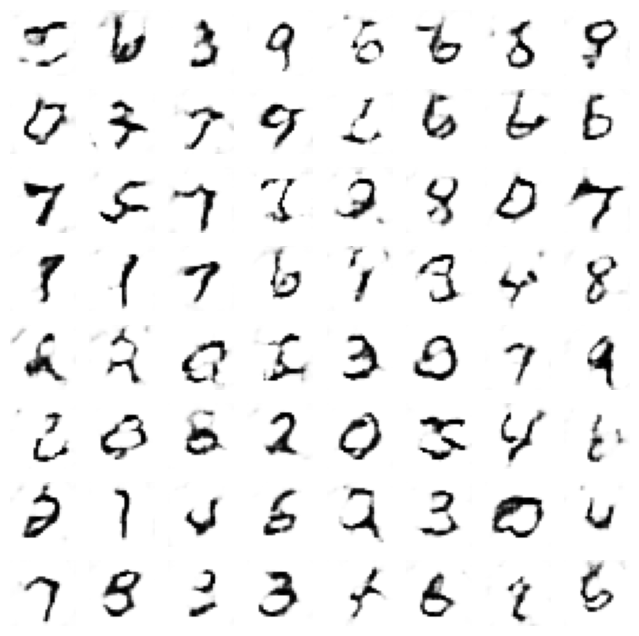

2/2 [==============================] - 0s 5ms/step
>11, 1/468, d1=0.704, d2=0.710 g=0.788
2/2 [==============================] - 0s 6ms/step
>11, 2/468, d1=0.693, d2=0.669 g=0.779
2/2 [==============================] - 0s 5ms/step
>11, 3/468, d1=0.653, d2=0.693 g=0.730
2/2 [==============================] - 0s 4ms/step
>11, 4/468, d1=0.672, d2=0.699 g=0.734
2/2 [==============================] - 0s 4ms/step
>11, 5/468, d1=0.661, d2=0.703 g=0.751
2/2 [==============================] - 0s 4ms/step
>11, 6/468, d1=0.672, d2=0.684 g=0.785
2/2 [==============================] - 0s 4ms/step
>11, 7/468, d1=0.687, d2=0.654 g=0.830
2/2 [==============================] - 0s 3ms/step
>11, 8/468, d1=0.720, d2=0.656 g=0.833
2/2 [==============================] - 0s 4ms/step
>11, 9/468, d1=0.689, d2=0.696 g=0.748
2/2 [==============================] - 0s 4ms/step
>11, 10/468, d1=0.656, d2=0.745 g=0.723
2/2 [==============================] - 0s 4ms/step
>11, 11/468, d1=0.702, d2=0.700 g=0.790
2/2 [===

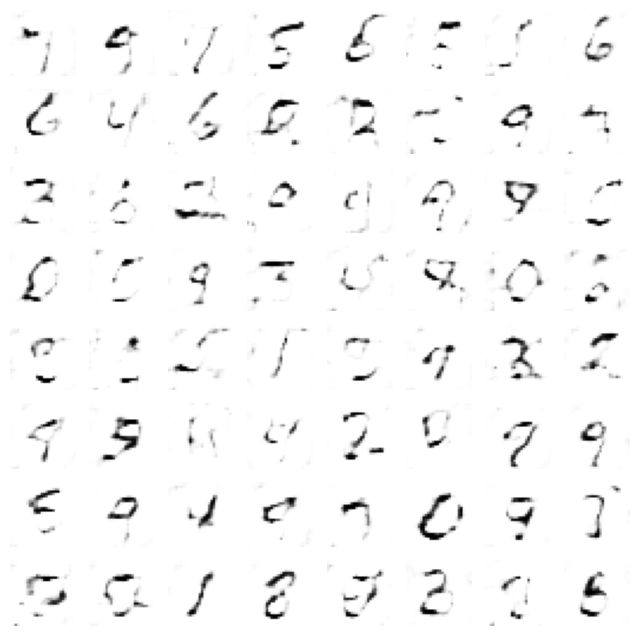

2/2 [==============================] - 0s 5ms/step
>12, 1/468, d1=0.657, d2=0.482 g=1.266
2/2 [==============================] - 0s 4ms/step
>12, 2/468, d1=0.588, d2=0.348 g=1.592
2/2 [==============================] - 0s 4ms/step
>12, 3/468, d1=0.624, d2=0.386 g=1.478
2/2 [==============================] - 0s 5ms/step
>12, 4/468, d1=0.582, d2=0.690 g=0.871
2/2 [==============================] - 0s 4ms/step
>12, 5/468, d1=0.543, d2=1.076 g=0.501
2/2 [==============================] - 0s 4ms/step
>12, 6/468, d1=0.568, d2=1.076 g=0.531
2/2 [==============================] - 0s 4ms/step
>12, 7/468, d1=0.608, d2=0.855 g=0.817
2/2 [==============================] - 0s 4ms/step
>12, 8/468, d1=0.614, d2=0.559 g=1.117
2/2 [==============================] - 0s 4ms/step
>12, 9/468, d1=0.673, d2=0.486 g=1.376
2/2 [==============================] - 0s 4ms/step
>12, 10/468, d1=0.637, d2=0.423 g=1.415
2/2 [==============================] - 0s 4ms/step
>12, 11/468, d1=0.688, d2=0.593 g=1.223
2/2 [===

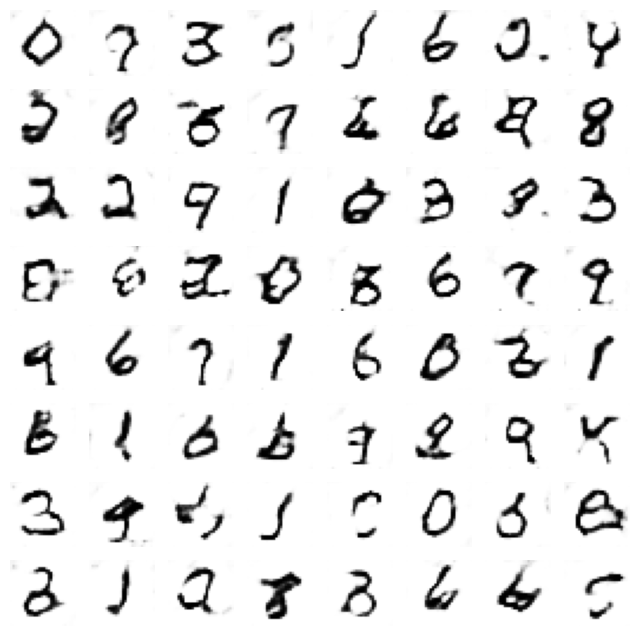

2/2 [==============================] - 0s 4ms/step
>13, 1/468, d1=0.702, d2=0.649 g=0.735
2/2 [==============================] - 0s 4ms/step
>13, 2/468, d1=0.675, d2=0.692 g=0.765
2/2 [==============================] - 0s 5ms/step
>13, 3/468, d1=0.656, d2=0.657 g=0.748
2/2 [==============================] - 0s 4ms/step
>13, 4/468, d1=0.700, d2=0.650 g=0.744
2/2 [==============================] - 0s 4ms/step
>13, 5/468, d1=0.696, d2=0.667 g=0.739
2/2 [==============================] - 0s 4ms/step
>13, 6/468, d1=0.703, d2=0.714 g=0.768
2/2 [==============================] - 0s 4ms/step
>13, 7/468, d1=0.671, d2=0.700 g=0.757
2/2 [==============================] - 0s 4ms/step
>13, 8/468, d1=0.657, d2=0.674 g=0.739
2/2 [==============================] - 0s 4ms/step
>13, 9/468, d1=0.703, d2=0.679 g=0.748
2/2 [==============================] - 0s 4ms/step
>13, 10/468, d1=0.682, d2=0.690 g=0.752
2/2 [==============================] - 0s 4ms/step
>13, 11/468, d1=0.689, d2=0.726 g=0.744
2/2 [===

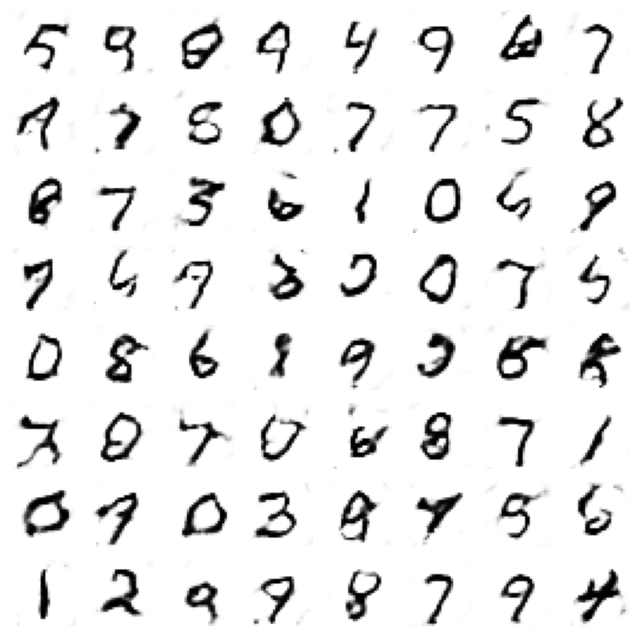

2/2 [==============================] - 0s 5ms/step
>14, 1/468, d1=0.689, d2=0.731 g=0.758
2/2 [==============================] - 0s 4ms/step
>14, 2/468, d1=0.649, d2=0.692 g=0.745
2/2 [==============================] - 0s 5ms/step
>14, 3/468, d1=0.716, d2=0.673 g=0.754
2/2 [==============================] - 0s 5ms/step
>14, 4/468, d1=0.688, d2=0.692 g=0.744
2/2 [==============================] - 0s 5ms/step
>14, 5/468, d1=0.686, d2=0.676 g=0.761
2/2 [==============================] - 0s 5ms/step
>14, 6/468, d1=0.671, d2=0.677 g=0.759
2/2 [==============================] - 0s 4ms/step
>14, 7/468, d1=0.686, d2=0.673 g=0.752
2/2 [==============================] - 0s 4ms/step
>14, 8/468, d1=0.696, d2=0.673 g=0.746
2/2 [==============================] - 0s 7ms/step
>14, 9/468, d1=0.689, d2=0.681 g=0.747
2/2 [==============================] - 0s 4ms/step
>14, 10/468, d1=0.715, d2=0.690 g=0.766
2/2 [==============================] - 0s 6ms/step
>14, 11/468, d1=0.656, d2=0.694 g=0.752
2/2 [===

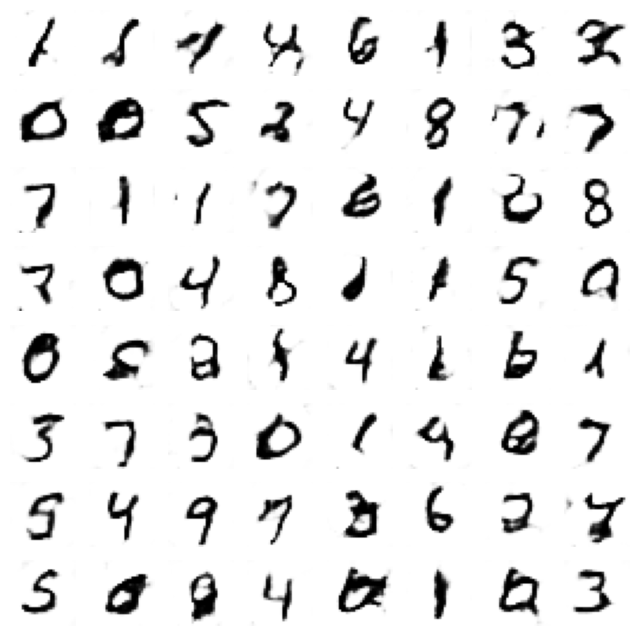

2/2 [==============================] - 0s 5ms/step
>15, 1/468, d1=0.663, d2=0.689 g=0.773
2/2 [==============================] - 0s 4ms/step
>15, 2/468, d1=0.657, d2=0.676 g=0.766
2/2 [==============================] - 0s 4ms/step
>15, 3/468, d1=0.692, d2=0.689 g=0.779
2/2 [==============================] - 0s 4ms/step
>15, 4/468, d1=0.682, d2=0.695 g=0.782
2/2 [==============================] - 0s 4ms/step
>15, 5/468, d1=0.672, d2=0.644 g=0.756
2/2 [==============================] - 0s 4ms/step
>15, 6/468, d1=0.650, d2=0.639 g=0.759
2/2 [==============================] - 0s 4ms/step
>15, 7/468, d1=0.685, d2=0.685 g=0.748
2/2 [==============================] - 0s 4ms/step
>15, 8/468, d1=0.699, d2=0.672 g=0.749
2/2 [==============================] - 0s 5ms/step
>15, 9/468, d1=0.654, d2=0.688 g=0.773
2/2 [==============================] - 0s 4ms/step
>15, 10/468, d1=0.663, d2=0.661 g=0.776
2/2 [==============================] - 0s 4ms/step
>15, 11/468, d1=0.688, d2=0.676 g=0.747
2/2 [===

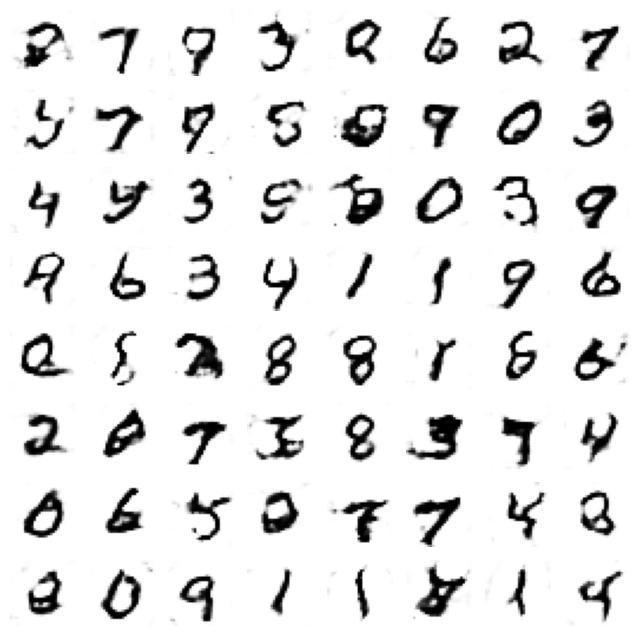

2/2 [==============================] - 0s 6ms/step
>16, 1/468, d1=0.680, d2=0.691 g=0.764
2/2 [==============================] - 0s 4ms/step
>16, 2/468, d1=0.663, d2=0.652 g=0.779
2/2 [==============================] - 0s 3ms/step
>16, 3/468, d1=0.666, d2=0.692 g=0.776
2/2 [==============================] - 0s 4ms/step
>16, 4/468, d1=0.688, d2=0.667 g=0.783
2/2 [==============================] - 0s 4ms/step
>16, 5/468, d1=0.663, d2=0.689 g=0.722
2/2 [==============================] - 0s 4ms/step
>16, 6/468, d1=0.714, d2=0.672 g=0.725
2/2 [==============================] - 0s 4ms/step
>16, 7/468, d1=0.685, d2=0.663 g=0.742
2/2 [==============================] - 0s 4ms/step
>16, 8/468, d1=0.659, d2=0.692 g=0.753
2/2 [==============================] - 0s 4ms/step
>16, 9/468, d1=0.644, d2=0.693 g=0.742
2/2 [==============================] - 0s 4ms/step
>16, 10/468, d1=0.654, d2=0.681 g=0.744
2/2 [==============================] - 0s 4ms/step
>16, 11/468, d1=0.712, d2=0.730 g=0.750
2/2 [===

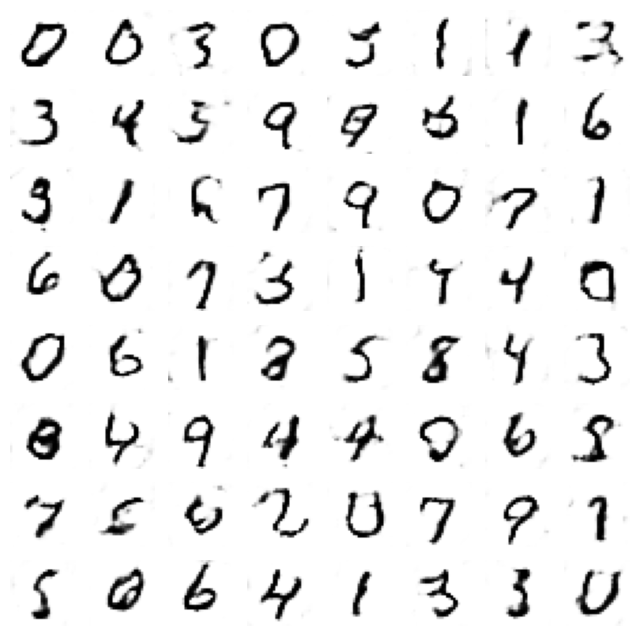

2/2 [==============================] - 0s 4ms/step
>17, 1/468, d1=0.670, d2=0.730 g=0.735
2/2 [==============================] - 0s 4ms/step
>17, 2/468, d1=0.648, d2=0.722 g=0.714
2/2 [==============================] - 0s 4ms/step
>17, 3/468, d1=0.704, d2=0.736 g=0.706
2/2 [==============================] - 0s 4ms/step
>17, 4/468, d1=0.671, d2=0.691 g=0.807
2/2 [==============================] - 0s 4ms/step
>17, 5/468, d1=0.677, d2=0.627 g=0.904
2/2 [==============================] - 0s 4ms/step
>17, 6/468, d1=0.672, d2=0.548 g=0.971
2/2 [==============================] - 0s 5ms/step
>17, 7/468, d1=0.733, d2=0.619 g=0.843
2/2 [==============================] - 0s 4ms/step
>17, 8/468, d1=0.710, d2=0.713 g=0.738
2/2 [==============================] - 0s 4ms/step
>17, 9/468, d1=0.653, d2=0.771 g=0.716
2/2 [==============================] - 0s 4ms/step
>17, 10/468, d1=0.708, d2=0.725 g=0.795
2/2 [==============================] - 0s 4ms/step
>17, 11/468, d1=0.706, d2=0.641 g=0.802
2/2 [===

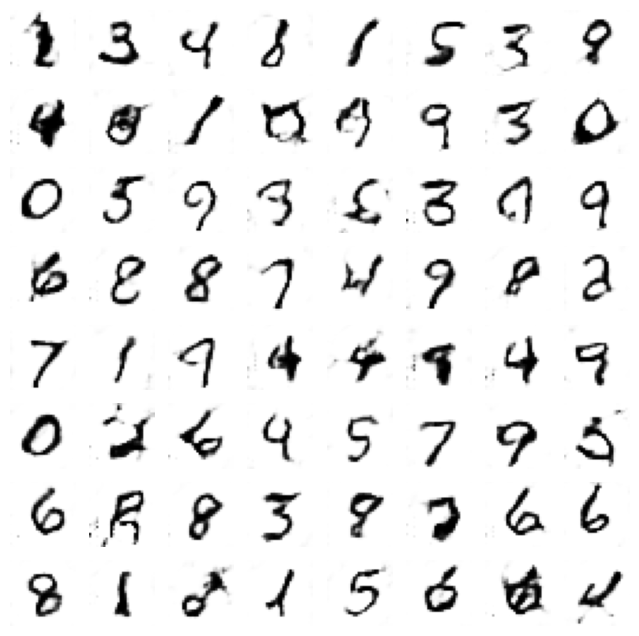

2/2 [==============================] - 0s 4ms/step
>18, 1/468, d1=0.672, d2=0.674 g=0.757
2/2 [==============================] - 0s 4ms/step
>18, 2/468, d1=0.647, d2=0.703 g=0.762
2/2 [==============================] - 0s 4ms/step
>18, 3/468, d1=0.683, d2=0.656 g=0.758
2/2 [==============================] - 0s 5ms/step
>18, 4/468, d1=0.663, d2=0.658 g=0.758
2/2 [==============================] - 0s 4ms/step
>18, 5/468, d1=0.699, d2=0.689 g=0.751
2/2 [==============================] - 0s 5ms/step
>18, 6/468, d1=0.705, d2=0.692 g=0.729
2/2 [==============================] - 0s 4ms/step
>18, 7/468, d1=0.673, d2=0.671 g=0.750
2/2 [==============================] - 0s 4ms/step
>18, 8/468, d1=0.670, d2=0.690 g=0.736
2/2 [==============================] - 0s 4ms/step
>18, 9/468, d1=0.642, d2=0.656 g=0.748
2/2 [==============================] - 0s 4ms/step
>18, 10/468, d1=0.677, d2=0.683 g=0.739
2/2 [==============================] - 0s 5ms/step
>18, 11/468, d1=0.724, d2=0.746 g=0.744
2/2 [===

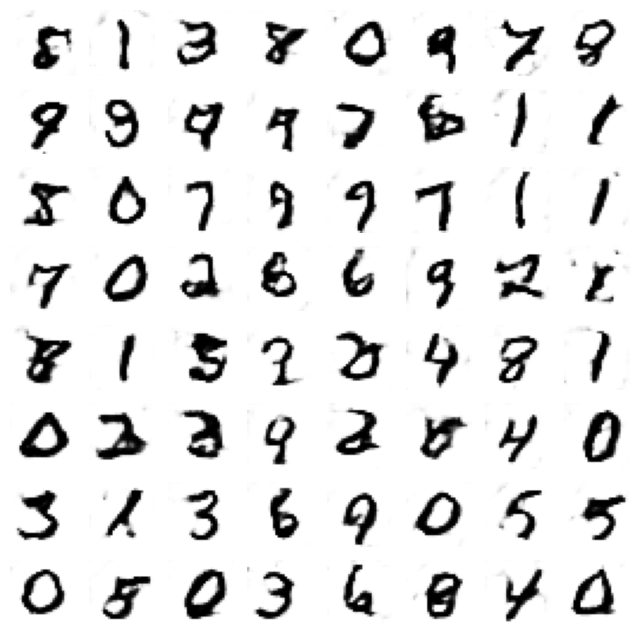

2/2 [==============================] - 0s 4ms/step
>19, 1/468, d1=0.729, d2=0.592 g=0.855
2/2 [==============================] - 0s 4ms/step
>19, 2/468, d1=0.657, d2=0.598 g=0.858
2/2 [==============================] - 0s 4ms/step
>19, 3/468, d1=0.705, d2=0.675 g=0.762
2/2 [==============================] - 0s 4ms/step
>19, 4/468, d1=0.694, d2=0.752 g=0.737
2/2 [==============================] - 0s 4ms/step
>19, 5/468, d1=0.673, d2=0.738 g=0.747
2/2 [==============================] - 0s 12ms/step
>19, 6/468, d1=0.688, d2=0.695 g=0.794
2/2 [==============================] - 0s 6ms/step
>19, 7/468, d1=0.672, d2=0.654 g=0.814
2/2 [==============================] - 0s 6ms/step
>19, 8/468, d1=0.663, d2=0.663 g=0.781
2/2 [==============================] - 0s 4ms/step
>19, 9/468, d1=0.678, d2=0.695 g=0.762
2/2 [==============================] - 0s 4ms/step
>19, 10/468, d1=0.691, d2=0.703 g=0.722
2/2 [==============================] - 0s 4ms/step
>19, 11/468, d1=0.661, d2=0.738 g=0.720
2/2 [==

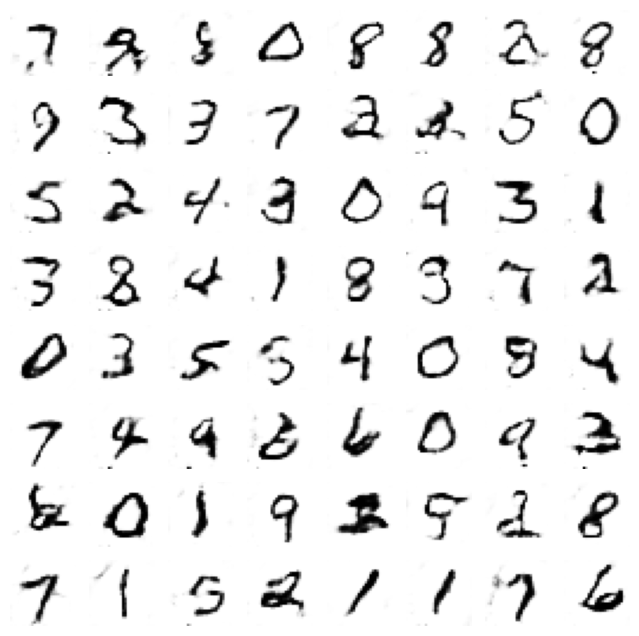

2/2 [==============================] - 0s 4ms/step
>20, 1/468, d1=0.700, d2=0.644 g=0.768
2/2 [==============================] - 0s 4ms/step
>20, 2/468, d1=0.664, d2=0.672 g=0.764
2/2 [==============================] - 0s 4ms/step
>20, 3/468, d1=0.666, d2=0.692 g=0.750
2/2 [==============================] - 0s 4ms/step
>20, 4/468, d1=0.673, d2=0.687 g=0.742
2/2 [==============================] - 0s 4ms/step
>20, 5/468, d1=0.679, d2=0.682 g=0.718
2/2 [==============================] - 0s 4ms/step
>20, 6/468, d1=0.676, d2=0.735 g=0.718
2/2 [==============================] - 0s 4ms/step
>20, 7/468, d1=0.658, d2=0.711 g=0.744
2/2 [==============================] - 0s 4ms/step
>20, 8/468, d1=0.657, d2=0.669 g=0.756
2/2 [==============================] - 0s 4ms/step
>20, 9/468, d1=0.706, d2=0.681 g=0.844
2/2 [==============================] - 0s 4ms/step
>20, 10/468, d1=0.698, d2=0.629 g=0.884
2/2 [==============================] - 0s 4ms/step
>20, 11/468, d1=0.671, d2=0.595 g=0.940
2/2 [===

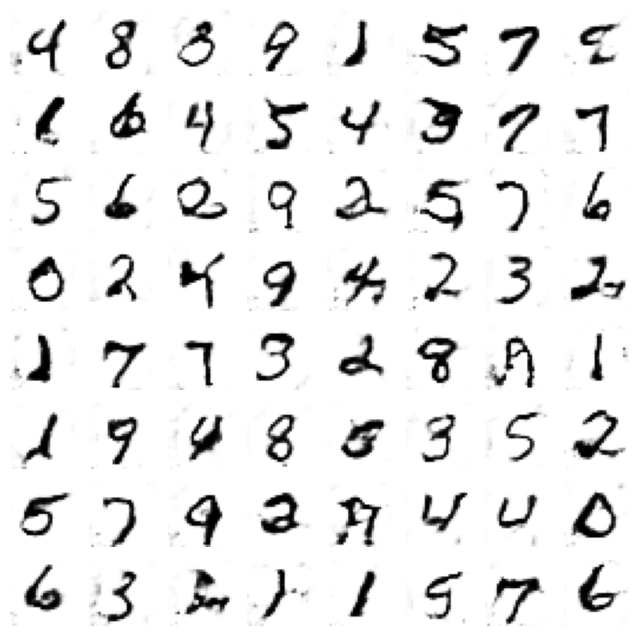

2/2 [==============================] - 0s 4ms/step
>21, 1/468, d1=0.634, d2=0.700 g=0.731
2/2 [==============================] - 0s 4ms/step
>21, 2/468, d1=0.683, d2=0.694 g=0.750
2/2 [==============================] - 0s 4ms/step
>21, 3/468, d1=0.702, d2=0.702 g=0.745
2/2 [==============================] - 0s 4ms/step
>21, 4/468, d1=0.682, d2=0.691 g=0.752
2/2 [==============================] - 0s 4ms/step
>21, 5/468, d1=0.678, d2=0.684 g=0.761
2/2 [==============================] - 0s 4ms/step
>21, 6/468, d1=0.646, d2=0.687 g=0.750
2/2 [==============================] - 0s 4ms/step
>21, 7/468, d1=0.650, d2=0.672 g=0.760
2/2 [==============================] - 0s 3ms/step
>21, 8/468, d1=0.677, d2=0.682 g=0.755
2/2 [==============================] - 0s 4ms/step
>21, 9/468, d1=0.697, d2=0.691 g=0.725
2/2 [==============================] - 0s 4ms/step
>21, 10/468, d1=0.675, d2=0.693 g=0.753
2/2 [==============================] - 0s 4ms/step
>21, 11/468, d1=0.723, d2=0.674 g=0.753
2/2 [===

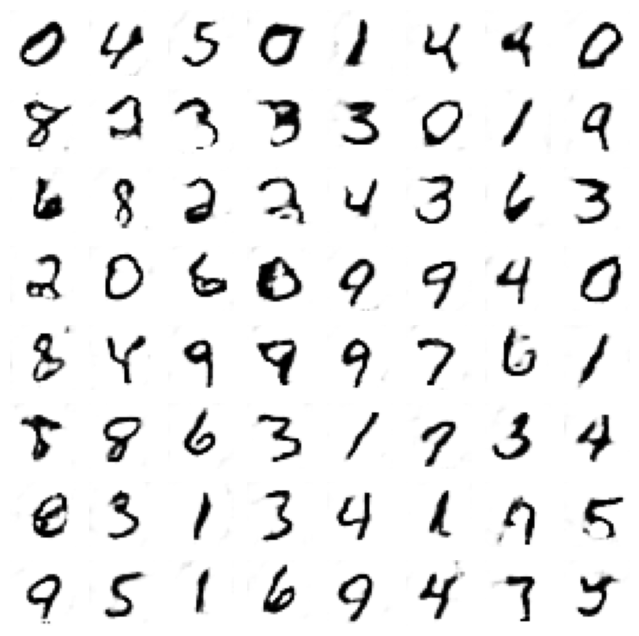

2/2 [==============================] - 0s 4ms/step
>22, 1/468, d1=0.709, d2=0.725 g=0.728
2/2 [==============================] - 0s 4ms/step
>22, 2/468, d1=0.719, d2=0.706 g=0.719
2/2 [==============================] - 0s 4ms/step
>22, 3/468, d1=0.683, d2=0.725 g=0.731
2/2 [==============================] - 0s 5ms/step
>22, 4/468, d1=0.689, d2=0.657 g=0.780
2/2 [==============================] - 0s 4ms/step
>22, 5/468, d1=0.664, d2=0.660 g=0.808
2/2 [==============================] - 0s 4ms/step
>22, 6/468, d1=0.695, d2=0.645 g=0.783
2/2 [==============================] - 0s 4ms/step
>22, 7/468, d1=0.689, d2=0.666 g=0.779
2/2 [==============================] - 0s 4ms/step
>22, 8/468, d1=0.680, d2=0.682 g=0.741
2/2 [==============================] - 0s 4ms/step
>22, 9/468, d1=0.742, d2=0.689 g=0.730
2/2 [==============================] - 0s 4ms/step
>22, 10/468, d1=0.704, d2=0.685 g=0.724
2/2 [==============================] - 0s 4ms/step
>22, 11/468, d1=0.690, d2=0.681 g=0.753
2/2 [===

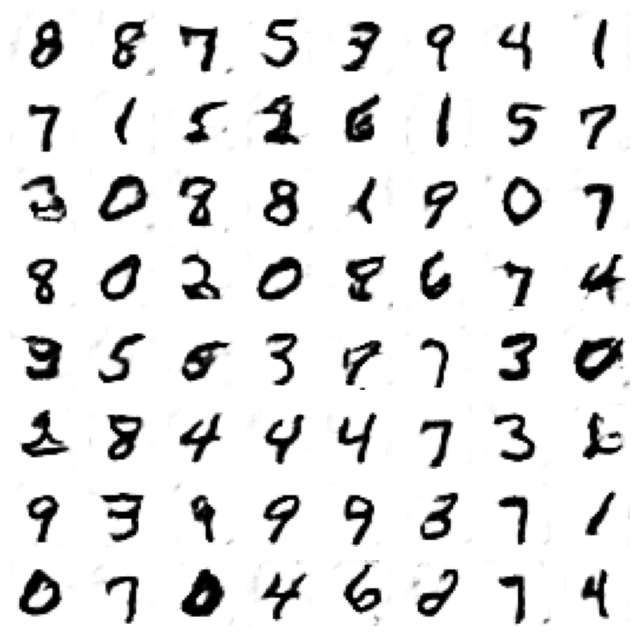

2/2 [==============================] - 0s 5ms/step
>23, 1/468, d1=0.647, d2=0.670 g=0.837
2/2 [==============================] - 0s 5ms/step
>23, 2/468, d1=0.712, d2=0.610 g=0.898
2/2 [==============================] - 0s 4ms/step
>23, 3/468, d1=0.722, d2=0.641 g=0.862
2/2 [==============================] - 0s 5ms/step
>23, 4/468, d1=0.705, d2=0.611 g=0.816
2/2 [==============================] - 0s 5ms/step
>23, 5/468, d1=0.660, d2=0.656 g=0.720
2/2 [==============================] - 0s 4ms/step
>23, 6/468, d1=0.682, d2=0.756 g=0.661
2/2 [==============================] - 0s 4ms/step
>23, 7/468, d1=0.710, d2=0.752 g=0.701
2/2 [==============================] - 0s 4ms/step
>23, 8/468, d1=0.680, d2=0.722 g=0.735
2/2 [==============================] - 0s 4ms/step
>23, 9/468, d1=0.667, d2=0.700 g=0.776
2/2 [==============================] - 0s 4ms/step
>23, 10/468, d1=0.646, d2=0.686 g=0.803
2/2 [==============================] - 0s 4ms/step
>23, 11/468, d1=0.687, d2=0.652 g=0.777
2/2 [===

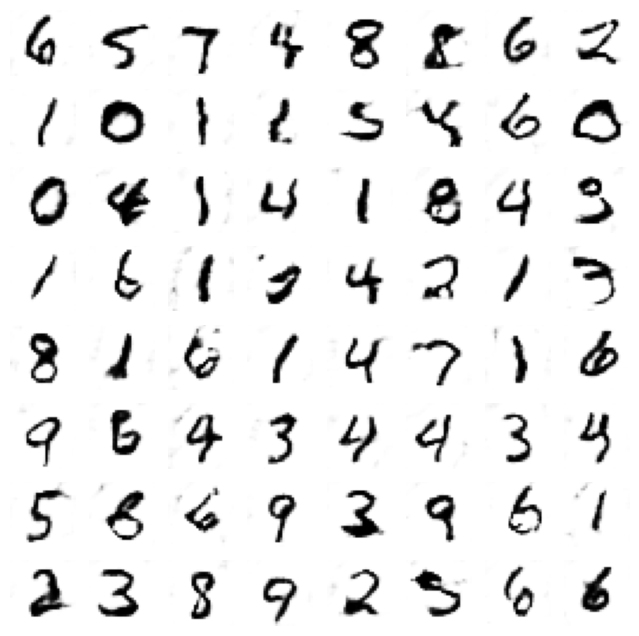

2/2 [==============================] - 0s 4ms/step
>24, 1/468, d1=0.695, d2=0.707 g=0.742
2/2 [==============================] - 0s 4ms/step
>24, 2/468, d1=0.699, d2=0.682 g=0.745
2/2 [==============================] - 0s 4ms/step
>24, 3/468, d1=0.708, d2=0.694 g=0.756
2/2 [==============================] - 0s 10ms/step
>24, 4/468, d1=0.652, d2=0.703 g=0.760
2/2 [==============================] - 0s 4ms/step
>24, 5/468, d1=0.667, d2=0.688 g=0.735
2/2 [==============================] - 0s 4ms/step
>24, 6/468, d1=0.708, d2=0.682 g=0.744
2/2 [==============================] - 0s 4ms/step
>24, 7/468, d1=0.653, d2=0.699 g=0.740
2/2 [==============================] - 0s 4ms/step
>24, 8/468, d1=0.696, d2=0.668 g=0.754
2/2 [==============================] - 0s 4ms/step
>24, 9/468, d1=0.678, d2=0.677 g=0.743
2/2 [==============================] - 0s 3ms/step
>24, 10/468, d1=0.669, d2=0.712 g=0.787
2/2 [==============================] - 0s 4ms/step
>24, 11/468, d1=0.683, d2=0.666 g=0.729
2/2 [==

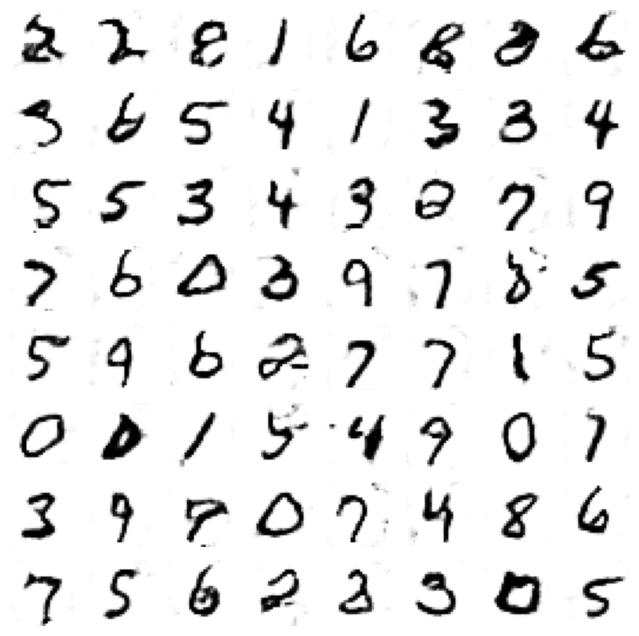

2/2 [==============================] - 0s 5ms/step
>25, 1/468, d1=0.671, d2=0.684 g=0.751
2/2 [==============================] - 0s 4ms/step
>25, 2/468, d1=0.685, d2=0.681 g=0.747
2/2 [==============================] - 0s 5ms/step
>25, 3/468, d1=0.676, d2=0.664 g=0.767
2/2 [==============================] - 0s 4ms/step
>25, 4/468, d1=0.672, d2=0.700 g=0.770
2/2 [==============================] - 0s 4ms/step
>25, 5/468, d1=0.705, d2=0.693 g=0.720
2/2 [==============================] - 0s 4ms/step
>25, 6/468, d1=0.702, d2=0.680 g=0.736
2/2 [==============================] - 0s 4ms/step
>25, 7/468, d1=0.676, d2=0.717 g=0.734
2/2 [==============================] - 0s 5ms/step
>25, 8/468, d1=0.713, d2=0.681 g=0.721
2/2 [==============================] - 0s 4ms/step
>25, 9/468, d1=0.664, d2=0.679 g=0.734
2/2 [==============================] - 0s 4ms/step
>25, 10/468, d1=0.673, d2=0.699 g=0.747
2/2 [==============================] - 0s 4ms/step
>25, 11/468, d1=0.670, d2=0.675 g=0.741
2/2 [===

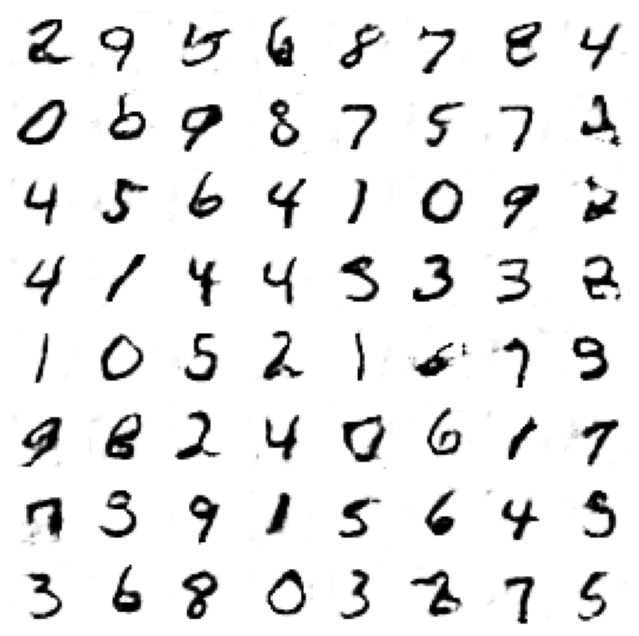

2/2 [==============================] - 0s 4ms/step
>26, 1/468, d1=0.715, d2=0.703 g=0.737
2/2 [==============================] - 0s 4ms/step
>26, 2/468, d1=0.677, d2=0.689 g=0.756
2/2 [==============================] - 0s 4ms/step
>26, 3/468, d1=0.693, d2=0.688 g=0.778
2/2 [==============================] - 0s 4ms/step
>26, 4/468, d1=0.650, d2=0.650 g=0.797
2/2 [==============================] - 0s 5ms/step
>26, 5/468, d1=0.683, d2=0.660 g=0.762
2/2 [==============================] - 0s 4ms/step
>26, 6/468, d1=0.651, d2=0.633 g=0.743
2/2 [==============================] - 0s 4ms/step
>26, 7/468, d1=0.636, d2=0.671 g=0.720
2/2 [==============================] - 0s 3ms/step
>26, 8/468, d1=0.696, d2=0.776 g=0.681
2/2 [==============================] - 0s 3ms/step
>26, 9/468, d1=0.677, d2=0.734 g=0.690
2/2 [==============================] - 0s 4ms/step
>26, 10/468, d1=0.686, d2=0.715 g=0.735
2/2 [==============================] - 0s 3ms/step
>26, 11/468, d1=0.692, d2=0.694 g=0.828
2/2 [===

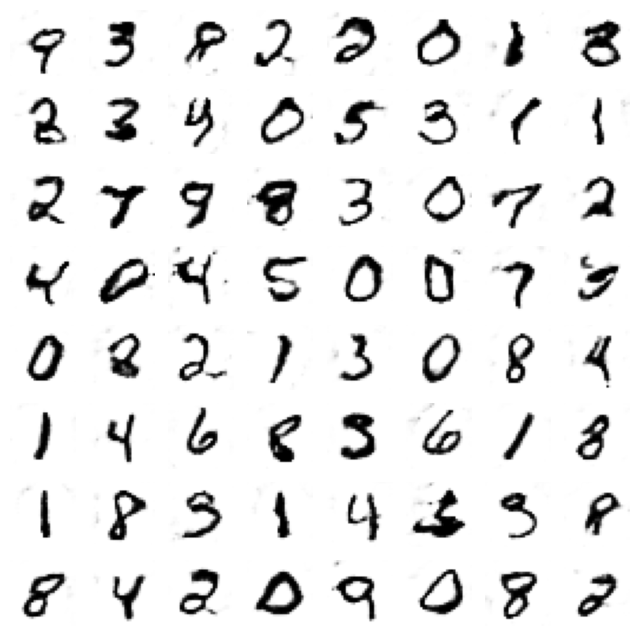

2/2 [==============================] - 0s 4ms/step
>27, 1/468, d1=0.656, d2=0.676 g=0.743
2/2 [==============================] - 0s 4ms/step
>27, 2/468, d1=0.685, d2=0.695 g=0.739
2/2 [==============================] - 0s 4ms/step
>27, 3/468, d1=0.682, d2=0.670 g=0.748
2/2 [==============================] - 0s 4ms/step
>27, 4/468, d1=0.707, d2=0.676 g=0.783
2/2 [==============================] - 0s 3ms/step
>27, 5/468, d1=0.687, d2=0.694 g=0.787
2/2 [==============================] - 0s 4ms/step
>27, 6/468, d1=0.682, d2=0.691 g=0.753
2/2 [==============================] - 0s 4ms/step
>27, 7/468, d1=0.680, d2=0.648 g=0.745
2/2 [==============================] - 0s 3ms/step
>27, 8/468, d1=0.692, d2=0.674 g=0.757
2/2 [==============================] - 0s 4ms/step
>27, 9/468, d1=0.668, d2=0.706 g=0.724
2/2 [==============================] - 0s 4ms/step
>27, 10/468, d1=0.693, d2=0.717 g=0.731
2/2 [==============================] - 0s 4ms/step
>27, 11/468, d1=0.696, d2=0.666 g=0.754
2/2 [===

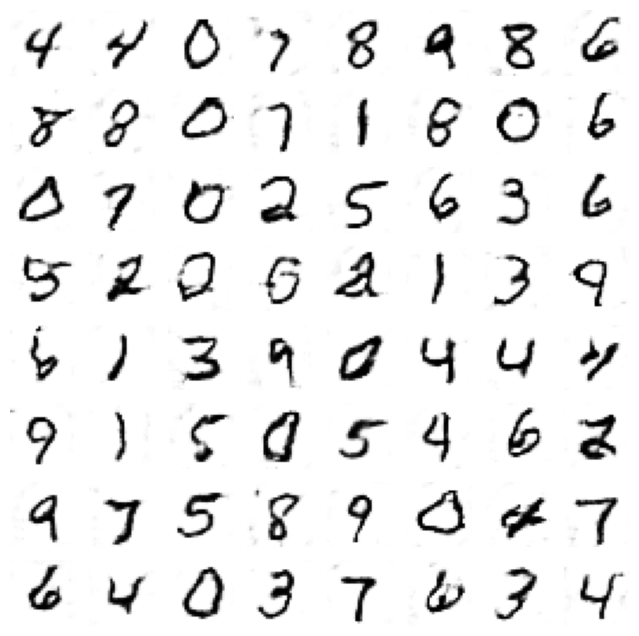

2/2 [==============================] - 0s 4ms/step
>28, 1/468, d1=0.673, d2=0.665 g=0.748
2/2 [==============================] - 0s 4ms/step
>28, 2/468, d1=0.654, d2=0.658 g=0.745
2/2 [==============================] - 0s 4ms/step
>28, 3/468, d1=0.676, d2=0.685 g=0.735
2/2 [==============================] - 0s 4ms/step
>28, 4/468, d1=0.670, d2=0.682 g=0.741
2/2 [==============================] - 0s 4ms/step
>28, 5/468, d1=0.676, d2=0.713 g=0.732
2/2 [==============================] - 0s 4ms/step
>28, 6/468, d1=0.702, d2=0.675 g=0.750
2/2 [==============================] - 0s 4ms/step
>28, 7/468, d1=0.719, d2=0.665 g=0.759
2/2 [==============================] - 0s 4ms/step
>28, 8/468, d1=0.686, d2=0.691 g=0.764
2/2 [==============================] - 0s 4ms/step
>28, 9/468, d1=0.677, d2=0.677 g=0.776
2/2 [==============================] - 0s 4ms/step
>28, 10/468, d1=0.690, d2=0.664 g=0.759
2/2 [==============================] - 0s 4ms/step
>28, 11/468, d1=0.715, d2=0.679 g=0.740
2/2 [===

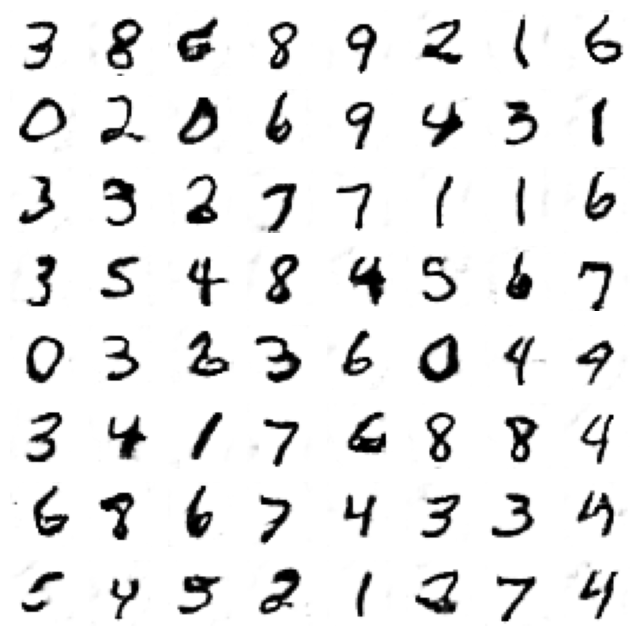

2/2 [==============================] - 0s 4ms/step
>29, 1/468, d1=0.690, d2=0.705 g=0.730
2/2 [==============================] - 0s 4ms/step
>29, 2/468, d1=0.687, d2=0.683 g=0.754
2/2 [==============================] - 0s 4ms/step
>29, 3/468, d1=0.673, d2=0.666 g=0.774
2/2 [==============================] - 0s 4ms/step
>29, 4/468, d1=0.651, d2=0.650 g=0.759
2/2 [==============================] - 0s 4ms/step
>29, 5/468, d1=0.683, d2=0.688 g=0.785
2/2 [==============================] - 0s 4ms/step
>29, 6/468, d1=0.659, d2=0.666 g=0.756
2/2 [==============================] - 0s 4ms/step
>29, 7/468, d1=0.688, d2=0.654 g=0.760
2/2 [==============================] - 0s 12ms/step
>29, 8/468, d1=0.678, d2=0.673 g=0.744
2/2 [==============================] - 0s 5ms/step
>29, 9/468, d1=0.669, d2=0.698 g=0.740
2/2 [==============================] - 0s 5ms/step
>29, 10/468, d1=0.704, d2=0.699 g=0.766
2/2 [==============================] - 0s 7ms/step
>29, 11/468, d1=0.665, d2=0.694 g=0.771
2/2 [==

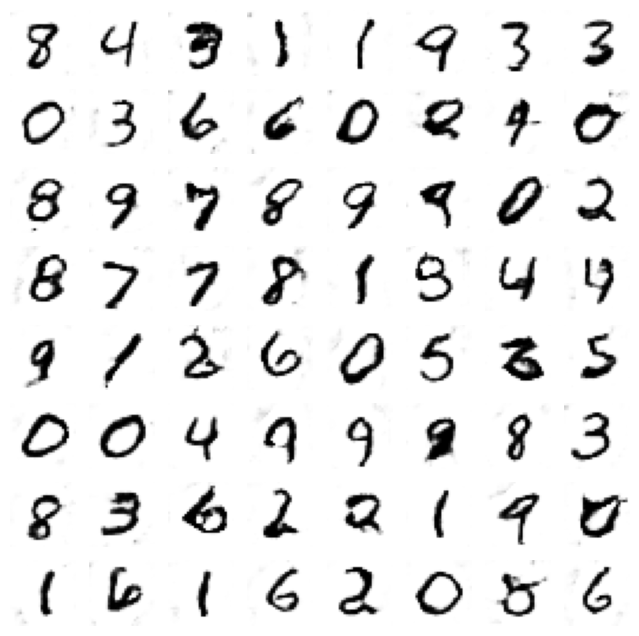

2/2 [==============================] - 0s 4ms/step
>30, 1/468, d1=0.668, d2=0.673 g=0.738
2/2 [==============================] - 0s 4ms/step
>30, 2/468, d1=0.664, d2=0.682 g=0.750
2/2 [==============================] - 0s 4ms/step
>30, 3/468, d1=0.689, d2=0.681 g=0.734
2/2 [==============================] - 0s 4ms/step
>30, 4/468, d1=0.683, d2=0.690 g=0.758
2/2 [==============================] - 0s 4ms/step
>30, 5/468, d1=0.687, d2=0.692 g=0.759
2/2 [==============================] - 0s 4ms/step
>30, 6/468, d1=0.684, d2=0.673 g=0.752
2/2 [==============================] - 0s 4ms/step
>30, 7/468, d1=0.693, d2=0.694 g=0.736
2/2 [==============================] - 0s 4ms/step
>30, 8/468, d1=0.660, d2=0.679 g=0.731
2/2 [==============================] - 0s 4ms/step
>30, 9/468, d1=0.682, d2=0.699 g=0.756
2/2 [==============================] - 0s 4ms/step
>30, 10/468, d1=0.674, d2=0.670 g=0.765
2/2 [==============================] - 0s 4ms/step
>30, 11/468, d1=0.677, d2=0.666 g=0.755
2/2 [===

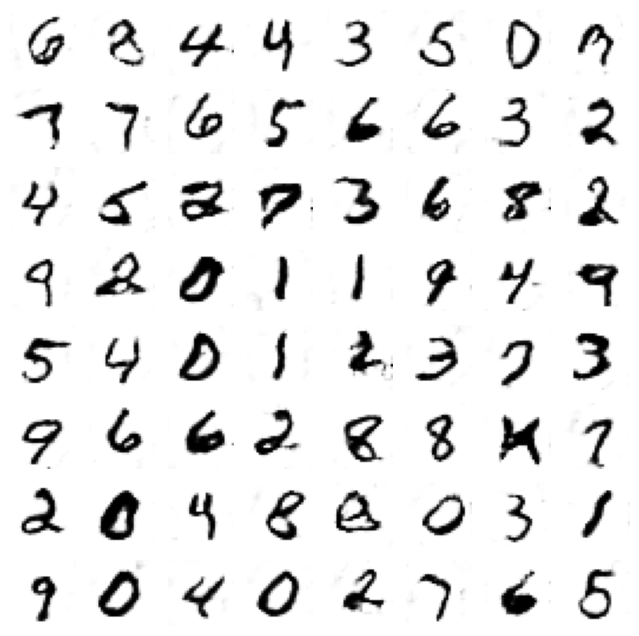

In [20]:
dataset = load_dataset()
train_gan(generator, discriminator, GAN, dataset, noise_size, n_epochs=30, n_batch=128)

## Using the Model to Generate Numbers. 
Now that we have a conditional GAN trained, we can generate images of any class we want. In our case, they are numbers that belong to the MNIST Dataset, that is, numbers from 0 to 9.

1/1 [==============================] - 0s 180ms/step


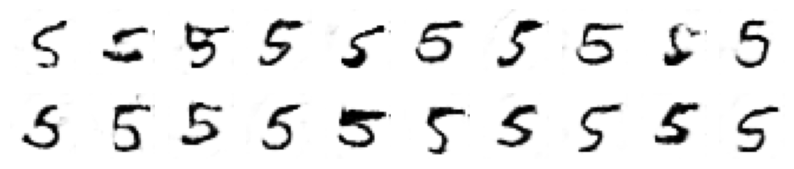

1/1 [==============================] - 0s 23ms/step


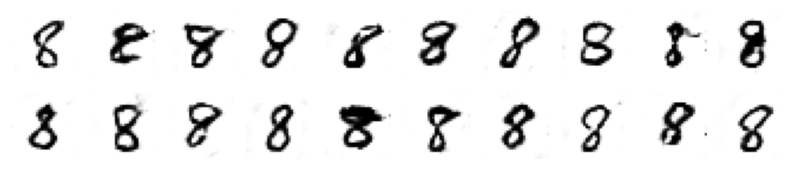

In [21]:
model = keras.models.load_model('cgan_generator.h5')

latent_points, labels = generate_noise(noise_size, 20)
labels = np.ones(20) * 5
X = model.predict([latent_points, labels])
plot_results(X, 10)

labels = np.ones(20) * 8
X = model.predict([latent_points, labels])
plot_results(X, 10)

# Conclusions Fork & Improve
## If you liked the notebook, please consider **upvoting it**. I will be very happy, and it encourages me to continue publishing.

Please, feel free to fork the notebook use and improve it!

Yo can change the Generator and The discrimionator, with less nodes and try to use the LeakyReLU activator as a independent layer oafter the BatchNormalization, instead of an activator inside the Conv2D layer. 

A very good exercise will be to try adding a new condition flag, maybe you can decide to output odd or even numbers.


All the other GAN's tutorials.  
**First DCGAN using TensorFlow:**
https://www.kaggle.com/code/peremartramanonellas/gan-tutorial-first-dcgan-using-tensorflow

**Generating Color Images:**
https://www.kaggle.com/code/peremartramanonellas/gan-tutorial-2-generating-color-images

**How to use TPUs to train a GAN.**
https://www.kaggle.com/code/peremartramanonellas/gan-tutorial-3-how-to-use-tpus-to-train-a-gan
